# Lab 1 - A*

Some implementations of the A* search algorithm ideated and programmed by **Claudio Savelli (s317680)** & **Mattia Sabato (s305849)** during a cold and rainy October. We have designed two algorithms in order to not only reach the goal in the **fastest way** but also in a **smart way**. We achieve this by **reducing the number of overlappings** and by forcing a solution which has the **smallest number of shared points** in the sets considered in the final solution. Even if slower, our solutions show better performances than the one proposed by the Professor when setting the number of overlappings as a major KPI.

**IMPORTANT**: all the relevant code and implementations were already committed **before the 23:59 of the 26th of October**, in order to meet the deadline. If you wish to see the better and latest version of the following notebook, you can just check the one corresponding to the last commit, which is sometimes updated to make it more appealing. Still, **all the important results and pieces of information were already provided in previous commits**. Enjoy!

## Methodology

Here we describe the two algorithms we have introduced to solve the set covering problem when minimizing the number of overlappings. Even though not perfect, we had a lot of fun while designing them and we hope to improve them further in the near future! We are not really sure if our implementations are actually a legal A*, but they work and we are happy about it. We have explored also other heuristics, playing with various distances and functions, but they did not give good results in terms of performance. Here we report the two that gave us the most interesting results.

- **Proximity**:

    We use as a heuristic the **closeness** between the goal and the candidate state by **summing up** the number of **marginal** points covered by the last. Intuitively, it will be picked the state which will help the most to get close to the final configuration. As a cost, we **sum up** the **point-wise overlappings** over all the sets and them we sum them to obtain a single value which measures how bad is the new state in terms of sovrappositions of tiles.

- **Cosine similarity**:

    In this case, we use as our heuristic the **cosine similarity** between the candidate state and the goal. Since we can think at each state as a vector in the space, the cosine similarity will increase when two vectors share a **similar direction**, which is a proxy for the state they are characterized by. In a certain sense, we aim to take a sequence of sets that, when summed, **move the resulting vector toward the goal**. As a cost, we use the **norm** of the resulting vector; the intuition is that when there are many overlappings, of course the norm will increase (even though the direction stays the same).

## Set up

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from random import random
from functools import reduce
from collections import namedtuple, deque
from queue import PriorityQueue, SimpleQueue
from time import time
from math import ceil
from tqdm.auto import tqdm
from random import seed
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# Define the configuration of the problem.
PROBLEM_SIZE = 16    # Number of points to be covered.
NUM_SETS = 200       # Number of sets in our pool.
ALPHA = 0.6          # Probability for a set to cover one point.

State = namedtuple('State', ['taken', 'not_taken'])

seed(42)
SETS = tuple(np.array([random() < ALPHA for _ in range(PROBLEM_SIZE)]) \
                for _ in range (NUM_SETS))

In [8]:
def goal_check(state: namedtuple) -> bool:
    '''
    Checks whether the problem is solvable and return `False` if not.
    '''
    return np.all(reduce(np.logical_or, [SETS[i] for i in state.taken], \
                         np.array([False for _ in range(PROBLEM_SIZE)])))


def proximity(state: namedtuple) -> int:
    '''
    Computes the proximity between a candidate state and the goal by
    summing the updated number of covered points.
    '''
    return sum(reduce(np.logical_or, [SETS[i] for i in state.taken],
               np.array([False for _ in range(PROBLEM_SIZE)])))


def cost(state: namedtuple) -> float:
    '''
    Computes the cost associated to a candidate state by summing the
    overlappings over the same point.
    '''
    if len(state.taken) <= 1:
        return 0
    elif 0 in np.array(take_state_from_set(state.taken)).sum(axis = 1):
        return np.inf
    else:

        state_vector = (np.array([SETS[i] for i in state.taken]).sum(axis = 0))
        state_vector[state_vector > 1]
        return sum(state_vector[state_vector > 1] - 1)


def count_overlappings(state: namedtuple) -> int:
    '''
    Computes the total number of overlappings returned by the current state.
    '''
    if len(state.taken) <= 1:
        return 0
    else:
        return cost(state)


def visualize_state(state: namedtuple, title: str) -> None:
    '''
    Visualize how does the state look like. Thanks Beatrice Occhiena!
    [https://github.com/beatrice-occhiena](https://github.com/beatrice-occhiena)
    '''
    plt.figure(figsize = (7, 2))
    plt.imshow(take_state_from_set(state.taken), cmap = 'RdPu', aspect = 'auto')
    plt.title(title)
    plt.xlabel("Problem Elements")
    plt.xticks(np.arange(PROBLEM_SIZE))
    plt.ylabel("Taken Sets")
    
    # On the ticks of the y axis, show the indices of the taken sets
    plt.yticks(np.arange(len(state.taken)), list(state.taken))
    plt.show()


def covered(state: namedtuple) -> np.ndarray:
    '''
    Returns an array of `bool` specifying whether a point has
    been covered or not.
    '''
    return reduce(np.logical_or, [SETS[i] for i in state.taken],
                  np.array([False for _ in range(PROBLEM_SIZE)]))


def h_prof_c_prof(state: namedtuple, h: str = 'h3') -> int:
    '''
    Choose from a family of herustics. Possible choices make use 
    of the distance between the goal and the candidate set in different ways :
    - `h1`, considers the biggest set;
    - `h2`, considers the biggest set which has not been taken yet;
    - `h3`, considers also the order.

    Here the associated cost is simply the number of states taken.
    '''
    
    if h == 'h1':

        largest_set_size = max(sum(s) for s in SETS)
        missing_size = PROBLEM_SIZE - sum(covered(state))
        optimistic_estimate = ceil(missing_size / largest_set_size) 
        
        return len(state.taken) + optimistic_estimate
    
    elif h == 'h2':

        already_covered = covered(state)
        
        if np.all(already_covered):
            return 0
        
        largest_set_size = max(sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS)
        missing_size = PROBLEM_SIZE - sum(already_covered)
        optimistic_estimate = ceil(missing_size / largest_set_size)
        
        return len(state.taken) + optimistic_estimate
    
    elif h == 'h3':

        already_covered = covered(state)
    
        if np.all(already_covered):
            return 0
        
        missing_size = PROBLEM_SIZE - sum(already_covered)
        candidates = sorted((sum(np.logical_and(s, np.logical_not(already_covered))) for s in SETS),
                            reverse = True)
        taken = 1
        
        while sum(candidates[:taken]) < missing_size:
            taken += 1
        
        return len(state.taken) + taken
    

def take_state_from_set(state: set) -> list: 
    '''
    Takes as input the id of each state and returns a matrix where:
    - each row is a state;
    - each column is a point;
    - the value represent whether the point is covered by the set.

    Useful for visualization purposes.
    '''
    res = []
    for elem in state:
        res.append(SETS[elem])
    return res


def naive_distance(state: namedtuple) -> int:
    '''
    Simply returns the number of uncovered states.
    '''
    return PROBLEM_SIZE - sum(covered(state))


def cos_similarity(state: namedtuple) -> float:
    '''
    Computes the cosine similarity between the actual state and the goal.
    '''
    return cosine_similarity(X = np.array(covered(state) * 1).reshape(1, -1),
                             Y = np.array([1 for _ in range(PROBLEM_SIZE)]).reshape(1, -1))


def cost_cos(state: namedtuple) -> float:
    '''
    Computes the cost considering the norm of the vector in order to avoid overlappings.
    '''
    if len(state.taken) <= 1:
        return 0
    elif 0 in np.array(take_state_from_set(state.taken)).sum(axis = 1):
        return np.inf
    else: 
        state_vector = (np.array([SETS[i] for i in state.taken]).sum(axis = 0))
        state_vector[state_vector == 1] = 0
        state_vector[state_vector > 0] = state_vector[state_vector > 0] - 1
        return np.linalg.norm(state_vector) / np.linalg.norm([1 for _ in range(PROBLEM_SIZE)])

    
assert goal_check(State(set(range(NUM_SETS)), set())), 'Problem not solvable'

## Experimental Results

Here we prove some results about the performance of our algorithms using as a baseline the one provided by the Prof. We have run several experiments setting `NUM_SETS = 200` and letting vary both `ALPHA` and `PROBLEM_SIZE` in order to test the performances in heterogeneous situations.

Notice there is a **huge** difference in terms of **speed** between the solutions, and this was actually expected since in ours we are imposing stricter conditions and so more computations. Our algorithms may benefit a lot from some sort of further optimization, but due to lack of time we were not able to implement it. Still, given our goal, the results is **more than satisfactory**! We actually were able to **minimize the overlappings** and streak a **good balance** with the number of tiles needed. Given the premises and the requirements, it is a success! We have won, Prof...

...or, at least, let us believe it.

P.S.: we would like to say **THANK YOU** to [Beatrice Occhiena](https://github.com/beatrice-occhiena), from which we have borrowed the function used to plot the sets. Good job!

| SIZE  | ALPHA | STRATEGY                       | STEPS                    | TILES                   | OVERLAPPINGS            | OVERLAPPINGS/TILES               |
|:-----:|:-----:|:------------------------------:|:------------------------:|:-----------------------:|:-----------------------:|:---------------------------------------:|
| 16    | 0.2   | prof <br> **prox** <br> **cos**  | 44 <br> **4** <br> **4**     | 3 <br> **4** <br> **4**  | 3 <br> **0** <br> **0**   | 1.00 <br> **0.00** <br> **0.00**              |
| 24    | 0.2   | prof <br> **prox** <br> **cos**<sup>☆</sup> | 86 <br> **5** <br> **6150** | 4 <br> **5** <br> **7** | 11 <br> **3** <br> **3** | 2.75 <br> **0.60** <br> **0.43** |
| 32    | 0.2   | prof <br> **prox** <br> cos<sup>☆☆</sup>   | 635 <br> **7** <br> ?        | 4 <br> **6** <br> ?      | 9 <br> **4** <br> ?       | 2.25 <br> **0.67** <br> ? |
| 16    | 0.4   | prof <br> prox <br> **cos**      | 2 <br> 5 <br> **21**         | 2 <br> 3 <br> **3**      | 3 <br> 2 <br> **1**       | 1.50 <br> 0.67 <br> **0.33**                  |
| 24    | 0.4   | **prof** <br> prox <br> **cos**  | **2** <br> 33 <br> **2**     | **2** <br> 4 <br> **2**  | **1** <br> 8 <br> **1**   | **0.50** <br> 2.00 <br> **0.50**             |
| 32    | 0.4   | prof <br> prox <br> **cos**      | 13 <br> 22 <br> **1394**     | 3 <br> 3 <br> **3**      | 12 <br> 10 <br> **6**     | 4.00 <br> 3.33 <br> **2.00**                  |
| 16    | 0.6   | prof <br> prox <br> **cos**      | 2 <br> 6 <br> **115**        | 2 <br> 2 <br> **2**      | 8 <br> 3 <br> **1**       | 4.00 <br> 1.50 <br> **0.50**                  |
| 24    | 0.6   | prof <br> prox <br> **cos**      | 2 <br> 13 <br> **262**       | 2 <br> 2 <br> **2**      | 10 <br> 6 <br> **4**      | 5.00 <br> 3.00 <br> **2.00**                  |
| 32    | 0.6   | prof <br> prox <br> **cos**      | 2 <br> 19 <br> **305**       | 2 <br> 2 <br> **2**      | 11 <br> 9 <br> **7**      | 5.50 <br> 4.50 <br> **3.50**                  |


<sup>☆</sup>In order to run this configuration we had to set `NUM_SETS = 100`, since otherwise the algorithm would have cannibalized the RAM and stop before reaching the goal. Furthermore, notice how, having less tiles actually has an impact on the goodness of the solution. The final results is characterized by more tiles (7, since the pool is half the size of its contenders) but still by a small number of overlappings.<br>
<sup>☆☆</sup>We were not able to run this configuration since the algorithm took too much time. From this and * we understand how `cos` suffers a lot from a large `PROBLEM_SIZE` and a too small `ALPHA`, and thus it can not be used in situations like these.

### Baseline (Prof solution)

2it [00:00,  4.39it/s]

Solved in 2 steps (2 tiles) in 458ms
Sets: {0, 38}
Overlappings: 8


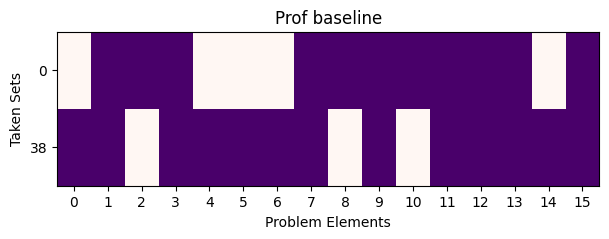

In [24]:
# BASELINE
frontier = PriorityQueue() 
state = State(set(), set(range(NUM_SETS)))
frontier.put((h_prof_c_prof(state), state))

counter = 0
_, current_state_prof = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_prof): 

        counter += 1

        for action in current_state_prof.not_taken:

            new_state = State(current_state_prof.taken ^ {action},
                              current_state_prof.not_taken ^ {action})
            frontier.put((h_prof_c_prof(new_state), new_state))
        
        _, current_state_prof = frontier.get()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state_prof.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_prof.taken}')
print(f'Overlappings: {count_overlappings(current_state_prof)}')

visualize_state(current_state_prof, 'Prof baseline')

### A* with proximity

0it [00:00, ?it/s]

6it [00:00, 72.52it/s]


Solved in 6 steps (2 tiles) in 87ms
Sets: {50, 53}
Overlappings: 3


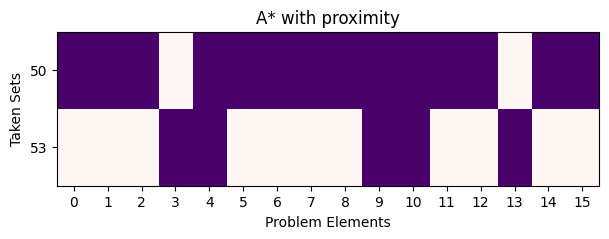

In [25]:
# PROXIMITY
frontier = PriorityQueue() 
state = State(set(), set(range(NUM_SETS)))
frontier.put((proximity(state), state))

counter = 0
_, current_state = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state): 

        counter += 1

        for action in current_state.not_taken:

            new_state = State(current_state.taken ^ {action},
                              current_state.not_taken ^ {action})
            frontier.put((cost(new_state) -  proximity(new_state), new_state))
        
        _, current_state = frontier.get()
        pbar.update(1)
    
toc = time()

print(f'Solved in {counter} steps ({len(current_state.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state.taken}')
print(f'Overlappings: {count_overlappings(current_state)}')

visualize_state(current_state, 'A* with proximity')

### A* with cosine similarity

0it [00:00, ?it/s]

115it [00:13,  8.76it/s]


Solved in 115 steps (2 tiles) in 13132ms
Sets: {29, 183}
Overlappings: 1


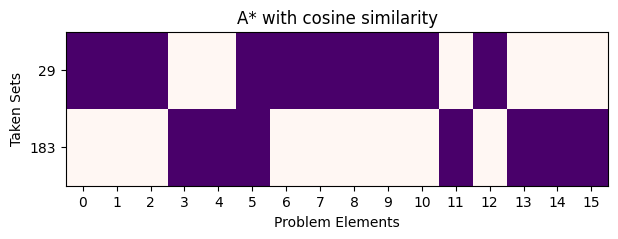

In [9]:
# COSINE SIMILARITY
frontier = PriorityQueue() 
state = State(set(), set(range(NUM_SETS)))
frontier.put((proximity(state), state))

counter = 0
_, current_state = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state): 

        counter += 1

        for action in current_state.not_taken:

            new_state = State(current_state.taken ^ {action},
                              current_state.not_taken ^ {action})
            frontier.put((cost_cos(new_state) - cos_similarity(new_state), new_state))
        
        _, current_state = frontier.get()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state.taken}')
print(f'Overlappings: {count_overlappings(current_state)}')

visualize_state(current_state, 'A* with cosine similarity')

## Additional

Here we have analyzed also other search algorithms in order to show their performance in terms of overlappings. Our solutions outperform all of them, even though more slowly sometimes.

### Breadth-First

238it [00:01, 196.41it/s]

Solved in 238 steps (2 tiles) in 1219ms
Sets: {0, 38}
Overlappings: 8


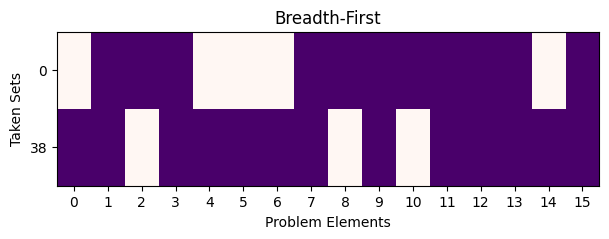

In [27]:
# BREADTH-FIRST
frontier = SimpleQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put(state)

counter = 0
current_state_bf = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_bf):
        
        counter += 1
        
        for action in current_state_bf.not_taken:
            
            new_state = State(
                current_state_bf.taken ^ {action},
                current_state_bf.not_taken ^ {action})
            frontier.put(new_state)
        
        current_state_bf = frontier.get()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state_bf.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_bf.taken}')
print(f'Overlappings: {count_overlappings(current_state_bf)}')

visualize_state(current_state_bf, 'Breadth-First')

### Depth-First

4it [00:00, 257.22it/s]


Solved in 4 steps (4 tiles) in 19ms
Sets: {196, 197, 198, 199}
Overlappings: 20


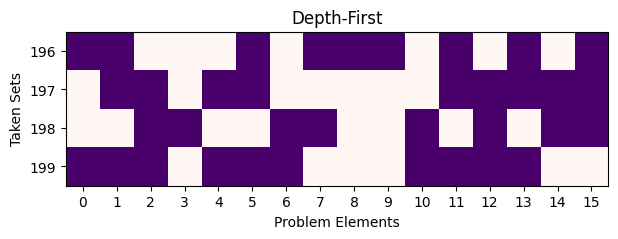

In [28]:
# DEPTH-FIRST
frontier = deque()
state = State(set(), set(range(NUM_SETS)))
frontier.append(state)

counter = 0
current_state_df = frontier.pop()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_df):

        counter += 1
        
        for action in current_state_df[1]:
            
            new_state = State(current_state_df.taken ^ {action},
                              current_state_df.not_taken ^ {action})
            frontier.append(new_state)
            
        current_state_df = frontier.pop()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state_df.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_df.taken}')
print(f'Overlappings: {count_overlappings(current_state_df)}')

visualize_state(current_state_df, 'Depth-First')

### Greedy Best-First

2it [00:00, 123.86it/s]


Solved in 2 steps (2 tiles) in 23ms
Sets: {0, 119}
Overlappings: 10


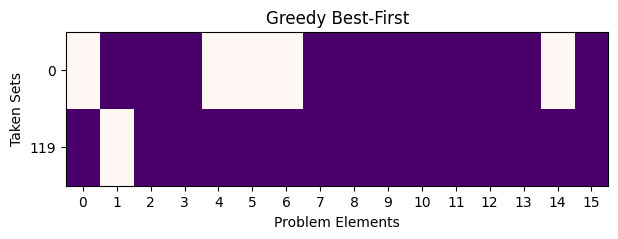

In [29]:
# GREEDY BEST-FIRST
frontier = PriorityQueue()
state = State(set(), set(range(NUM_SETS)))
frontier.put((naive_distance(state), state))

counter = 0
_, current_state_gbf = frontier.get()

tic = time()

with tqdm(total = None) as pbar:
    while not goal_check(current_state_gbf):
        
        counter += 1
        
        for action in current_state_gbf[1]:
            
            new_state = State(
                current_state_gbf.taken ^ {action},
                current_state_gbf.not_taken ^ {action})
            frontier.put((naive_distance(new_state), new_state))
        
        _, current_state_gbf = frontier.get()
        pbar.update(1)

toc = time()

print(f'Solved in {counter} steps ({len(current_state_gbf.taken)} tiles) \
in {(toc - tic)*1000:.0f}ms')
print(f'Sets: {current_state_gbf.taken}')
print(f'Overlappings: {count_overlappings(current_state_gbf)}')

visualize_state(current_state_gbf, 'Greedy Best-First')